_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 4

In this notebook you will work with preprocessed 2 photon calcium recordings, that have already been converted into spike counts for a population of cells from the Macaque V1. During the experiment the animal has been presented with several drifting grating stimuli, in response to which the neural activity was recorded. In this exercise sheet we will study how you can visualize the activity of multiple neural spike trains and assess whether a neuron is selective to a specific stimulus type.

Download the data files ```nds_cl_4_*.csv``` from ILIAS and save it in the subfolder ```../data/```. We recommend you to use a subset of the data for testing and debugging, ideally focus on a single cell (e.g. cell number x). The spike times and stimulus conditions are read in as pandas data frames. You can solve the exercise by making heavy use of that, allowing for many quite compact computations. See [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html) and several good [tutorials](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python#gs.L37i87A) on how to do this. Of course, converting the data into classical numpy arrays is also valid.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt

from scipy import signal as signal
from typing import Tuple

import itertools

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-16 16:44:30Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.35.0

sklearn: 1.6.1

seaborn   : 0.13.2
numpy     : 2.2.5
matplotlib: 3.10.1
pandas    : 2.2.3
scipy     : 1.15.2

Watermark: 2.5.0



In [2]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [3]:
spikes = pd.read_csv("../data/nds_cl_4_spiketimes.csv")  # neuron id, spike time
stims = pd.read_csv("../data/nds_cl_4_stimulus.csv")  # stimulus onset in ms, direction

stimDur = 2000.0  # in ms
nTrials = 11  # number of trials per condition
nDirs = 16  # number of conditions
deltaDir = 22.5  # difference between conditions

stims["StimOffset"] = stims["StimOnset"] + stimDur

We require some more information about the spikes for the plots and analyses we intend to make later. With a solution based on dataframes, it is natural to compute this information here and add it as additional columns to the `spikes` dataframe by combining it with the `stims` dataframe. We later need to know which condition (`Dir`) and trial (`Trial`) a spike was recorded in, the relative spike times compared to stimulus onset of the stimulus it was recorded in (`relTime`) and whether a spike was during the stimulation period (`stimPeriod`). But there are many options how to solve this exercise and you are free to choose any of them.

In [4]:
# you may add computations as specified above
spikes["Dir"] = np.nan  # stimulus direction
spikes["relTime"] = np.nan  # time since stimulus onset
spikes["Trial"] = np.nan  # trial number (within each direction)
spikes["stimPeriod"] = (
    np.nan
)  # boolean flag marking if a spike has occured during stimulus

dirs = np.unique(stims["Dir"])  # unique stimulus directions
trialcounter = np.zeros_like(dirs)

for i, row in stims.iterrows():
    trialcounter[dirs == row["Dir"]] += 1

    i0 = spikes["SpikeTimes"] > row["StimOnset"]  # spikes after stimulus onset
    i1 = spikes["SpikeTimes"] < row["StimOffset"]  # spikes before stimulus onset

    select = i0.values & i1.values  # true when spike occured in stimulus window

    spikes.loc[select, "Dir"] = row["Dir"]  # stimulus direction of spike
    spikes.loc[select, "Trial"] = trialcounter[dirs == row["Dir"]][
        0
    ]  # current trail count
    spikes.loc[select, "relTime"] = (
        spikes.loc[select, "SpikeTimes"] - row["StimOnset"]
    )  # time since stimulus onset
    spikes.loc[select, "stimPeriod"] = True  # marks that spike has (not) occured

spikes = spikes.dropna()  # drop spikes that were never inside any stimulus window

C:\Users\Florian\AppData\Local\Temp\ipykernel_2168\826546146.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  spikes.loc[select, "stimPeriod"] = True  # marks that spike has (not) occured


In [5]:
spikes.head()

,Neuron,SpikeTimes,Dir,relTime,Trial,stimPeriod
514,1,15739.000000,270.0,169.000000,1.0,True
515,1,15776.566667,270.0,206.566667,1.0,True
516,1,15808.466667,270.0,238.466667,1.0,True
517,1,15821.900000,270.0,251.900000,1.0,True
518,1,15842.966667,270.0,272.966667,1.0,True


In [14]:
unique_values_Trial = spikes["Trial"].nunique()
unique_values_Dir = spikes["Dir"].nunique()
print("\nNumber of unique values in 'Trial' column:", unique_values_Trial)
print("\nNumber of unique values in 'Dir' column:", unique_values_Dir)


Number of unique values in 'Trial' column: 11

Number of unique values in 'Dir' column: 16


## Task 1: Plot spike rasters

In a raster plot, each spike is shown by a small tick at the time it occurs relative to stimulus onset. Implement a function `plotRaster()` that plots the spikes of one cell as one trial per row, sorted by conditions (similar to what you saw in the lecture). Why are there no spikes in some conditions and many in others?

If you opt for a solution without a dataframe, you need to change the interface of the function.

*Grading: 3 pts*


In [6]:
def plotRaster(spikes: pd.DataFrame, neuron: int):
    """plot spike rasters for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    # -------------------------------------------------
    # Write a raster plot function for the data (2 pts)
    # -------------------------------------------------

    # filter neuron ID from dataframe
    df = spikes[spikes["Neuron"] == neuron]
    if df.empty:
        raise ValueError(f"No spikes found for neuron {neuron}")

    plt.figure(figsize=(8, 6))
    plt.scatter(
        df["relTime"],
        df["Dir"],
        marker="|",
        s=50,  # length of each tick
        color="black",
        alpha=0.8,
    )
    plt.xlabel("Time relative to stimulus onset (ms)")
    plt.ylabel("Direction of motion (degrees)")
    plt.title("Spike raster: time vs. direction (all neurons)")
    plt.ylim(spikes["Dir"].min() - 5, df["Dir"].max() + 5)
    plt.xlim(spikes["relTime"].min(), df["relTime"].max())
    plt.grid(False)
    plt.tight_layout()
    plt.show()

C:\Users\Florian\AppData\Local\Temp\ipykernel_2168\3110728062.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


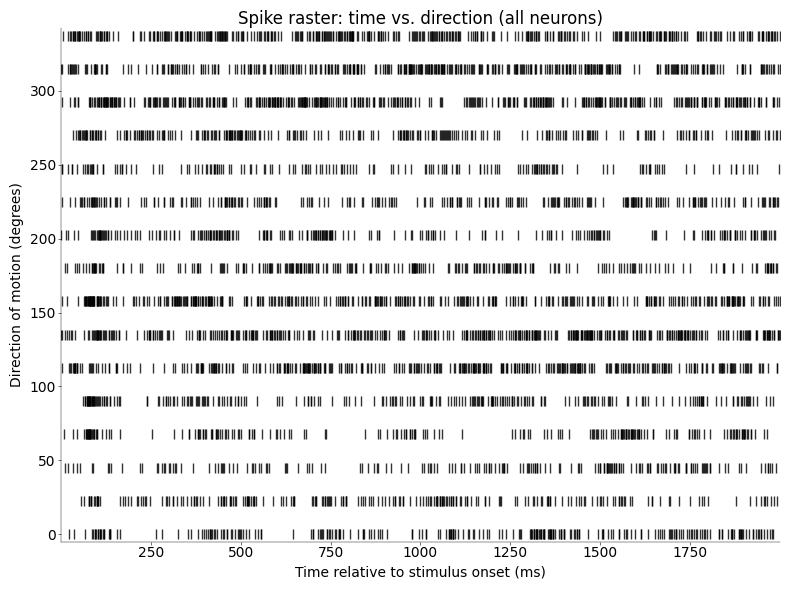

In [7]:
plotRaster(spikes, neuron=8)

Find examples of 
1. a direction selective neuron
2. an orientation selective neuron 
3. neither

and explain your choices.

C:\Users\Florian\AppData\Local\Temp\ipykernel_2168\2560903272.py:41: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.96])


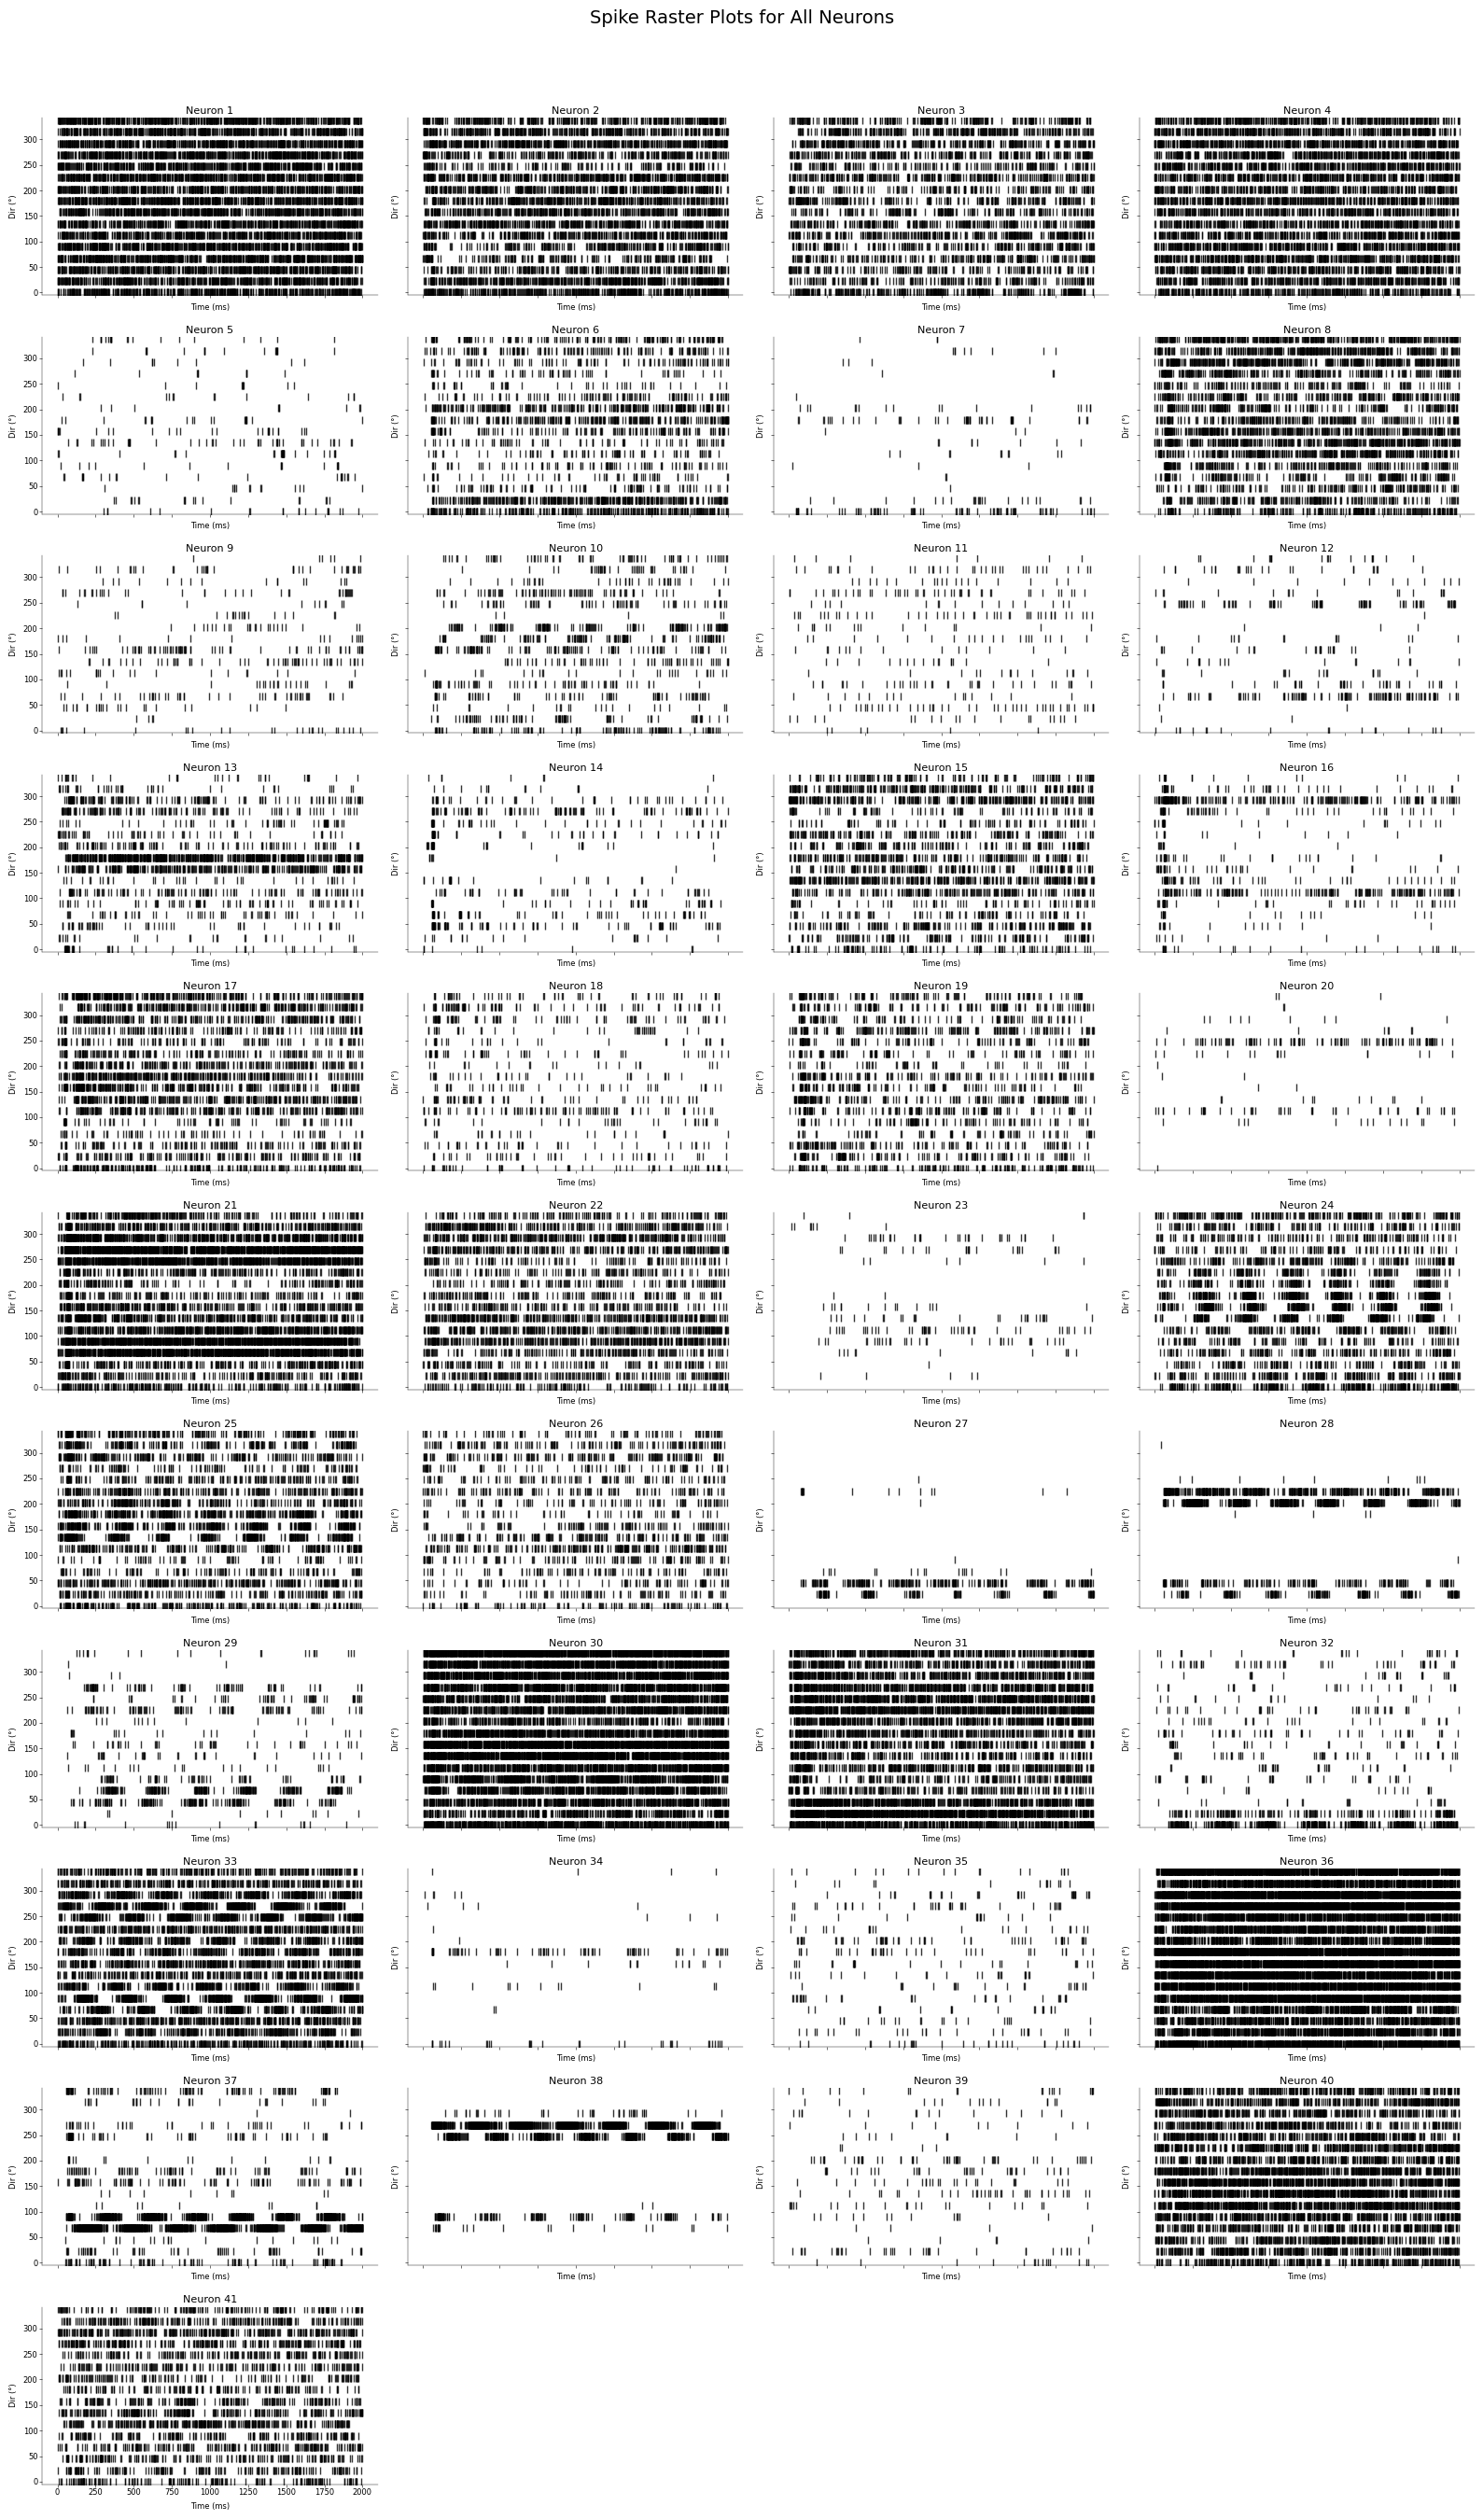

In [9]:
# ---------------------------------
# Find and explain examples? (1 pt)
# ---------------------------------

neuron_ids = spikes["Neuron"].unique()
n = len(neuron_ids)
ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 4, nrows * 2.5),
    sharex=True,
    sharey=True,
)
axes = axes.flatten()

for i, neuron_id in enumerate(neuron_ids):
    ax = axes[i]
    df = spikes[spikes["Neuron"] == neuron_id]

    if df.empty:
        ax.set_title(f"Neuron {neuron_id}: No data")
        ax.axis("off")
        continue

    ax.scatter(df["relTime"], df["Dir"], marker="|", s=40, color="black", alpha=0.8)
    ax.set_title(f"Neuron {neuron_id}", fontsize=8)
    ax.set_xlabel("Time (ms)", fontsize=6)
    ax.set_ylabel("Dir (°)", fontsize=6)
    ax.tick_params(labelsize=6)
    ax.set_ylim(spikes["Dir"].min() - 5, spikes["Dir"].max() + 5)
    ax.grid(False)

# Turn off any remaining empty axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Spike Raster Plots for All Neurons", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

C:\Users\Florian\AppData\Local\Temp\ipykernel_2168\1662069930.py:43: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.92])


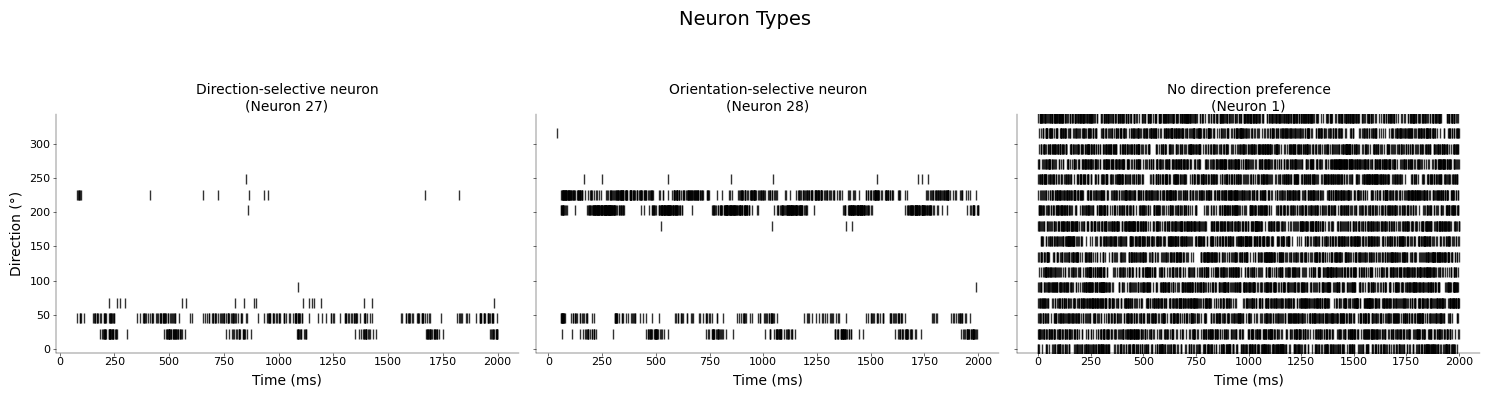

In [10]:
def plotThreeNeuronTypes(spikes: pd.DataFrame, neurons: list[int]):
    """
    Plot 3 raster plots side by side for specified neurons,
    labeled as direction-selective, orientation-selective, and non-selective.

    Parameters
    ----------
    spikes : pd.DataFrame
        DataFrame with columns: 'Neuron', 'SpikeTimes', 'Dir', 'relTime', 'Trial', 'stimPeriod'
    neurons : list of int
        List of exactly 3 neuron IDs [direction_selective, orientation_selective, no_preference]
    """
    if len(neurons) != 3:
        raise ValueError("Please provide exactly 3 neuron IDs.")

    labels = [
        "Direction-selective neuron",
        "Orientation-selective neuron",
        "No direction preference",
    ]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

    for i, (neuron_id, title) in enumerate(zip(neurons, labels)):
        ax = axes[i]
        df = spikes[spikes["Neuron"] == neuron_id]

        if df.empty:
            ax.set_title(f"{title}\n(Neuron {neuron_id})\nNo data")
            ax.axis("off")
            continue

        ax.scatter(df["relTime"], df["Dir"], marker="|", s=50, color="black", alpha=0.8)
        ax.set_title(f"{title}\n(Neuron {neuron_id})", fontsize=10)
        ax.set_xlabel("Time (ms)")
        if i == 0:
            ax.set_ylabel("Direction (°)")
        ax.set_ylim(spikes["Dir"].min() - 5, spikes["Dir"].max() + 5)
        ax.grid(False)
        ax.tick_params(labelsize=8)

    fig.suptitle("Neuron Types", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


plotThreeNeuronTypes(spikes, neurons=[27, 28, 1])

#### Neuron 27:
    The neuron is almost only spiking after stimuli with a direction of about 25-50 degrees but not really after stimuli with a direction of about 205-230 degrees (Which would be the same orientation but a different direction)

#### Neuron 28:
    Here we see that the neuron is spiking heavily after stimuli with a direction of 25-50 and after stimuli with a direction of 205-230 degrees. This means that the neuron reacts to the orientation of the stimulus but not to the direction (at least not heavily, it still seems to be spiking more heavily after stimuli in the range of 205-230 degrees but that seems to be the case with all orientation-selective neurons as seen in the raster of all neurons)

#### Neuron 1:
    Here we could have chosen a lot of neurons but it is clear that neuron 1 seems to not react at all to the direction of the stimulus (if at all to the stimulus) as it spikes heavily over the whole time and after all stimulus directions

## Task 2: Plot spike density functions

Compute an estimate of the spike rate against time relative to stimulus onset. There are two ways:
* Discretize time: Decide on a bin size, count the spikes in each bin and average across trials. 
* Directly estimate the probability of spiking using a density estimator with specified kernel width. 

For full points, the optimal kernel- or bin-width needs to be computed.

Implement one of them in the function `plotPSTH()`. If you dont use a dataframe you may need to change the interface of the function.


*Grading: 4 pts*


In [11]:
import numpy as np
import matplotlib.pyplot as plt


def plotPSTH(spikes: pd.DataFrame, neuron: int):
    """Plot PSTH for a single neuron, stacking per-direction histograms
    with automatic vertical spacing so bars never overlap.

    Parameters
    ----------
    spikes: pd.DataFrame
        Columns ['Neuron','SpikeTimes','Dir','relTime','Trial','stimPeriod'].
    neuron: int
        Neuron ID.
    """
    # 1) Filter to this neuron & only in‐stimulus spikes
    df = spikes[(spikes["Neuron"] == neuron) & (spikes["stimPeriod"])]
    if df.empty:
        raise ValueError(f"No in‐stimulus spikes for neuron {neuron}")

    # 2) Unique directions & time window
    dirs = np.sort(df["Dir"].unique())
    T = df["relTime"].max()  # ms
    n_dirs = len(dirs)

    # 3) Compute optimal bins & rates per direction
    psth_info = {}  # dir -> (edges, Δ_opt, rate_array)
    global_max = 0.0  # track tallest bar (spikes/s)
    for d in dirs:
        times = df.loc[df["Dir"] == d, "relTime"].values
        n_trials = df.loc[df["Dir"] == d, "Trial"].nunique()

        # Shimazaki–Shinomoto scan N=1…200 => Δ = T/N
        N_cand = np.arange(1, 201)
        deltas = T / N_cand
        costs = np.empty_like(deltas)
        for i, (N, Δ) in enumerate(zip(N_cand, deltas)):
            edges = np.linspace(0, T, N + 1)
            k = np.histogram(times, bins=edges)[0]
            costs[i] = (2 * k.mean() - k.var(ddof=0)) / ((n_trials * Δ) ** 2)

        best = np.argmin(costs)
        Δ_opt = deltas[best]
        edges = np.linspace(0, T, N_cand[best] + 1)

        # counts per bin
        counts = np.histogram(times, bins=edges)[0]
        # convert to spikes/s: k_i / (n_trials * Δ_in_seconds)
        rate = counts / (n_trials * (Δ_opt / 1000.0))

        psth_info[d] = (edges, Δ_opt, rate)
        global_max = max(global_max, rate.max())

    # 4) Compute vertical spacing so bars never overlap
    pad = 0.2 * global_max
    spacing = global_max + pad
    # map each direction to a baseline y
    y_base = {d: i * spacing for i, d in enumerate(dirs)}

    # 5) Plot
    plt.figure(figsize=(8, 6))
    for d in dirs:
        edges, Δ, rate = psth_info[d]
        plt.bar(
            edges[:-1],
            rate,
            width=Δ,
            bottom=y_base[d],
            align="edge",
            color="black",
            edgecolor="none",
            alpha=0.8,
        )

    # 6) Style
    yticks = [y_base[d] for d in dirs]
    ylabels = [f"{int(d)}°" for d in dirs]
    plt.yticks(yticks, ylabels)
    plt.xlabel("Time relative to stimulus onset (ms)")
    plt.ylabel("Direction of motion")
    plt.title(f"PSTH (neuron {neuron}) — firing rate (spikes/s)")
    plt.xlim(0, T)
    plt.ylim(-spacing * 0.1, spacing * (n_dirs - 1) + spacing * 0.1)
    plt.tight_layout()
    plt.show()

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_4371/1171297034.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


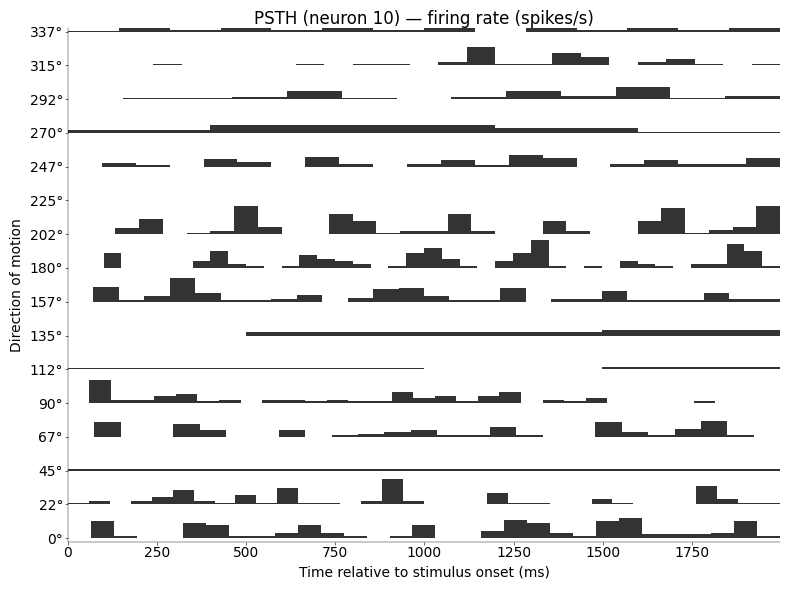

In [93]:
plotPSTH(spikes, neuron=10)

Plot the same 3 examples you selected in Task 1

In [12]:
# komplizierte Version


def plotPSTH(spikes: pd.DataFrame, neuron: int, M_sub: int = 5):
    """Plot PSTH for a single neuron, with within‐bin mini‐histograms
    and vertical dashed lines marking the optimal macro‐bin edges.

    Parameters
    ----------
    spikes: pd.DataFrame
        Must contain columns
          ['Neuron','SpikeTimes','Dir','relTime','Trial','stimPeriod'].
    neuron: int
        Neuron ID.
    M_sub: int
        Number of sub‐bins per optimal macro‐bin.
    """
    # 1) filter to neuron & in‐stimulus spikes
    df = spikes[(spikes["Neuron"] == neuron) & (spikes["stimPeriod"])]
    if df.empty:
        raise ValueError(f"No in‐stimulus spikes for neuron {neuron}")

    # 2) get directions, T, and row‐spacing
    dirs = np.sort(df["Dir"].unique())
    T = df["relTime"].max()
    delta_dir = np.diff(dirs).mean()

    # 3) compute optimal macro‐bins per direction
    psth_bins = {}
    for d in dirs:
        times = df.loc[df["Dir"] == d, "relTime"].values
        n_trials = df.loc[df["Dir"] == d, "Trial"].nunique()

        # scan N=1…200 → Δ=T/N
        N_cand = np.arange(1, 201)
        deltas = T / N_cand
        costs = np.empty_like(deltas)
        for i, (N, Δ) in enumerate(zip(N_cand, deltas)):
            edges = np.linspace(0, T, N + 1)
            k = np.histogram(times, bins=edges)[0]
            costs[i] = (2 * k.mean() - k.var(ddof=0)) / (n_trials * Δ) ** 2

        best = np.argmin(costs)
        Δ_opt = deltas[best]
        edges = np.linspace(0, T, N_cand[best] + 1)
        psth_bins[d] = (edges, Δ_opt)

    # 4) plot
    plt.figure(figsize=(8, 6))
    for d in dirs:
        edges, Δ = psth_bins[d]

        # mark macro‐bin boundaries with dashed lines
        y0 = d - delta_dir / 2
        y1 = d + delta_dir / 2
        for x in edges:
            plt.vlines(
                x, y0, y1, linestyle="--", color="gray", linewidth=0.8, alpha=0.7
            )

        # within each macro‐bin, draw mini‐histogram of spike‐times
        for left, right in zip(edges[:-1], edges[1:]):
            spikes_in_bin = df.loc[
                (df["Dir"] == d) & (df["relTime"] >= left) & (df["relTime"] < right),
                "relTime",
            ].values
            if spikes_in_bin.size == 0:
                continue

            local = spikes_in_bin - left
            sub_edges = np.linspace(0, Δ, M_sub + 1)
            sub_counts, _ = np.histogram(local, bins=sub_edges)

            # width of each mini‐bar & vertical scale
            w_sub = sub_edges[1] - sub_edges[0]
            h_scale = 0.8 * delta_dir / max(sub_counts.max(), 1)

            for j, cnt in enumerate(sub_counts):
                x0 = left + sub_edges[j]
                h = cnt * h_scale
                plt.bar(
                    x0,
                    h,
                    width=w_sub,
                    bottom=d,
                    align="edge",
                    color="black",
                    edgecolor="none",
                    alpha=0.8,
                )

    # 5) styling
    plt.xlabel("Time relative to stimulus onset (ms)")
    plt.ylabel("Direction of motion (°)")
    plt.title(f"PSTH with bin‐boundaries (neuron {neuron})")
    plt.yticks(dirs)
    plt.xlim(0, T)
    plt.ylim(dirs.min() - delta_dir, dirs.max() + delta_dir)
    plt.tight_layout()
    plt.show()

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_4371/359337652.py:103: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


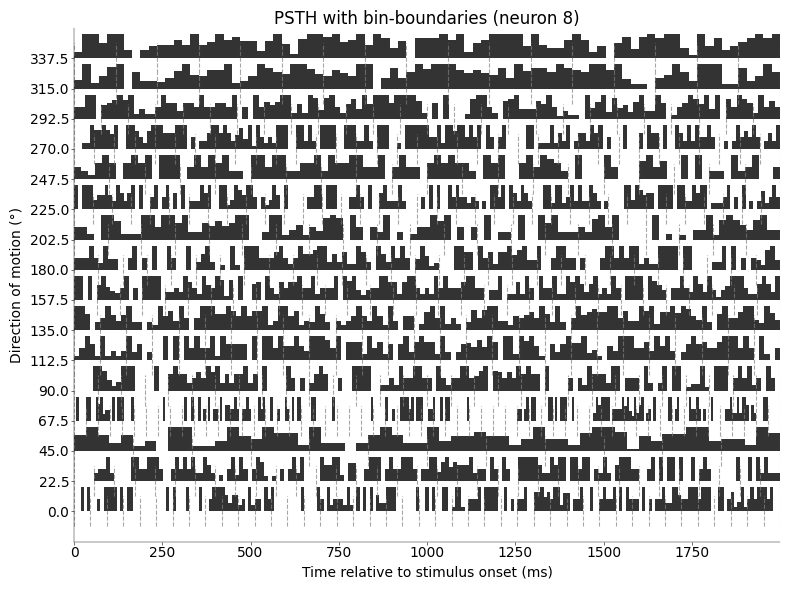

In [83]:
plotPSTH(spikes, neuron=8)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plotPSTH(spikes: pd.DataFrame, neuron: int):
    """Plot PSTH for a single neuron, showing for each time-bin
    the distribution of spike-counts across trials as a mini-histogram
    stacked at y = Dir."""

    # 1) Filter to the chosen neuron & in-stimulus spikes
    df = spikes[(spikes["Neuron"] == neuron) & (spikes["stimPeriod"])]
    if df.empty:
        raise ValueError(f"No in-stimulus spikes for neuron {neuron}")

    # 2) Unique, sorted directions and total window T
    dirs = np.sort(df["Dir"].unique())
    T = df["relTime"].max()  # e.g. 2000 ms
    n_trials = df["Trial"].nunique()

    # 3) Precompute bin edges & Δ* per direction via Shimazaki–Shinomoto
    psth_bins = {}  # psth_bins[d] = (edges, Δ_opt)
    for d in dirs:
        times = df.loc[df["Dir"] == d, "relTime"].values

        # scan N=1..200 → Δ=T/N
        N_cand = np.arange(1, 201)
        deltas = T / N_cand
        costs = np.empty_like(deltas)
        for i, (N, Δ) in enumerate(zip(N_cand, deltas)):
            edges = np.linspace(0, T, N + 1)
            k = np.histogram(times, bins=edges)[0]
            costs[i] = (2 * k.mean() - k.var(ddof=0)) / (n_trials * Δ) ** 2

        best = np.argmin(costs)
        Δ_opt = deltas[best]
        edges = np.linspace(0, T, N_cand[best] + 1)
        psth_bins[d] = (edges, Δ_opt)

    # 4) Now draw a big figure, stacking one “row” per Dir:
    plt.figure(figsize=(8, 6))
    delta_dir = np.diff(dirs).mean()  # spacing between rows

    for d in dirs:
        edges, Δ = psth_bins[d]
        # for each time-bin compute trial-wise counts
        for left, right in zip(edges[:-1], edges[1:]):
            # count spikes in [left,right) **per trial**
            counts = (
                df[(df["Dir"] == d)]
                .groupby("Trial")
                .apply(
                    lambda g: ((g["relTime"] >= left) & (g["relTime"] < right)).sum()
                )
                .reindex(range(1, n_trials + 1), fill_value=0)
                .values
            )
            # build mini-histogram of counts
            freqs = np.bincount(counts, minlength=counts.max() + 1)
            # how wide to draw each sub-bar?
            M = len(freqs)
            w_sub = Δ / (M + 1)

            # scale frequencies so hist fits within row spacing
            height_scale = 0.8 * delta_dir / freqs.max()

            # draw each bar of that mini-histogram
            for k_val, f in enumerate(freqs):
                x0 = left + (k_val + 0.5) * w_sub
                h = f * height_scale
                plt.bar(
                    x0,  # sub-bar center
                    h,  # scaled frequency
                    width=w_sub * 0.9,  # slight gap
                    bottom=d,  # baseline at y=Dir
                    align="center",
                    color="black",
                    edgecolor="none",
                )

    # 5) Style
    plt.xlabel("Time relative to stimulus onset (ms)")
    plt.ylabel("Direction of motion (°)")
    plt.title(f"PSTH‐distribution (neuron {neuron})")
    plt.yticks(dirs)
    plt.xlim(0, T)
    plt.ylim(dirs.min() - delta_dir, dirs.max() + delta_dir)
    plt.tight_layout()
    plt.show()

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_4371/933138469.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ((g['relTime'] >= left) & (g['relTime'] < right)).sum())
/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_4371/933138469.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ((g['relTime'] >= left) & (g['relTime'] < right)).sum())
/var/fol

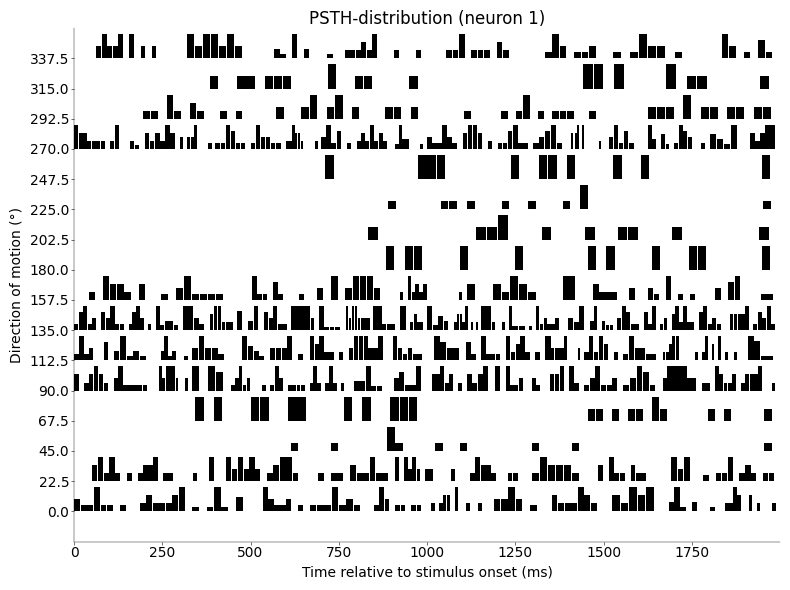

In [78]:
plotPSTH(spikes, neuron=1)

## Task 3: Fit and plot tuning functions

The goal is to visualize the activity of each neuron as a function of stimulus direction. First, compute the spike counts of each neuron for each direction of motion and trial.  The result should be a matrix `x`, where $x_{jk}$ represents the spike count of the $j$-th response to the $k$-th direction of motion (i.e. each column contains the spike counts for all trials with one direction of motion).	If you used dataframes above, the `groupby()` function allows to implement this very compactly. Make sure you don't loose trials with zero spikes though. Again, other implementations are completely fine.

Fit the tuning curve, i.e. the average spike count per direction, using a von Mises model. To capture the non-linearity and direction selectivity of the neurons, we will fit a modified von Mises function:

$$ f(\theta) = \exp(\alpha + \kappa (\cos (2*(\theta-\phi))-1) + \nu (\cos (\theta-\phi)-1))$$

Here, $\theta$ is the stimulus direction. Implement the von Mises function in `vonMises()` and plot it to understand how to interpret its parameters $\phi$, $\kappa$, $\nu$, $\alpha$. Perform a non-linear least squares fit using a package/function of your choice. Implement the fitting in `tuningCurve()`. 

Plot the average number of spikes per direction, the spike counts from individual trials as well as your optimal fit.

Select two cells that show nice tuning to test your code.

*Grading: 5 pts*

In [50]:
def vonMises(θ: np.ndarray, α: float, κ: float, ν: float, ϕ: float) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    # -----------------------------------
    # Implement the Mises model (0.5 pts)
    # -----------------------------------

    pass

Plot the von Mises function while varying the parameters systematically.

In [51]:
# ------------------------------------------------------------------------------
# plot von Mises curves with varying parameters and explain what they do (2 pts)
# ------------------------------------------------------------------------------

In [52]:
def tuningCurve(counts: np.ndarray, dirs: np.ndarray, show: bool = True) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.


    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """

    # ----------------------------------------
    # Compute the spike count matrix (0.5 pts)
    # ----------------------------------------

    # ------------------------------------------------------------
    # fit the von Mises tuning curve to the spike counts (0.5 pts)
    # ------------------------------------------------------------

    if show:
        # --------------------------------------------
        # plot the data and fitted tuning curve (1 pt)
        # --------------------------------------------
        pass

Plot tuning curve and fit for different neurons. Good candidates to check are 28, 29 or 37. 

In [15]:
def get_data(spikes, neuron):
    spk_by_dir = (
        spikes[spikes["Neuron"] == neuron]
        .groupby(["Dir", "Trial"])["stimPeriod"]
        .sum()
        .astype(int)
        .reset_index()
    )

    dirs = spk_by_dir["Dir"].values
    counts = spk_by_dir["stimPeriod"].values

    # because we count spikes only when they are present, some zero entries in the count vector are missing
    for i, Dir in enumerate(np.unique(spikes["Dir"])):
        m = nTrials - np.sum(dirs == Dir)
        if m > 0:
            dirs = np.concatenate((dirs, np.ones(m) * Dir))
            counts = np.concatenate((counts, np.zeros(m)))

    idx = np.argsort(dirs)
    dirs_sorted = dirs[idx]  # sorted dirs
    counts_sorted = counts[idx]

    return dirs_sorted, counts_sorted

In [54]:
# ----------------------------------------------------------
# plot the average number of spikes per direction, the spike
# counts from individual trials as well as your optimal fit
# for different neurons (0.5 pts)
# ----------------------------------------------------------

## Task 4: Permutation test for direction tuning

Implement a permutation test to quantitatively assess whether a neuron is direction/orientation selective. To do so, project the vector of average spike counts, $m_k=\frac{1}{N}\sum_j x_{jk}$ on a complex exponential with two cycles, $v_k = \exp(\psi i \theta_k)$, where $\theta_k$ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the fourier component to test (1: direction, 2: orientation). Denote the projection by $q=m^Tv$. The magnitude $|q|$ tells you how much power there is in the $\psi$-th fourier component. 

Estimate the distribution of |q| under the null hypothesis that the neuron fires randomly across directions by running 1000 iterations where you repeat the same calculation as above but on a random permutation of the trials (that is, randomly shuffle the entries in the spike count matrix x). The fraction of iterations for which you obtain a value more extreme than what you observed in the data is your p-value. Implement this procedure in the function ```testTuning()```. 

Illustrate the test procedure for one of the cells from above. Plot the sampling distribution of |q| and indicate the value observed in the real data in your plot. 

How many cells are tuned at p < 0.01?

*Grading: 3 pts*


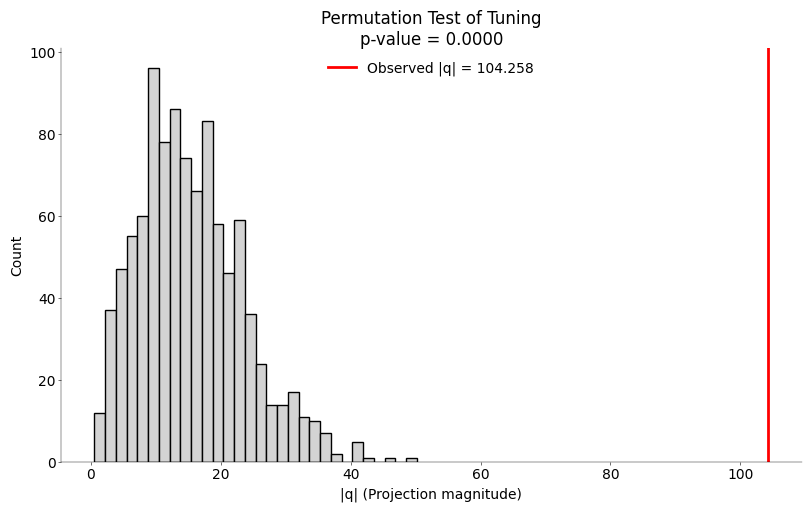

In [46]:
dirs_sorted, counts_sorted = get_data(spikes, 28)



In [49]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
) -> Tuple[float, float, np.ndarray]:
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    random_seed: int
        Random seed for reproducibility.

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """
    # -------------------------------
    # calculate m, nu and q (0.5 pts)
    # -------------------------------
    # m
    unique_dirs = np.unique(dirs)
    m = np.zeros(len(unique_dirs))

    for i, direction in enumerate(unique_dirs):
        m[i] = counts[dirs == direction].mean()
    # nu
    theta_k = np.deg2rad(unique_dirs)  # get radiants
    v = np.exp(1j * psi * theta_k)  # compute complex exponent

    # q
    q = np.dot(m, v)
    q_mag = np.abs(q)

    # -------------------------------------------------------------------------
    # Estimate the distribution of q under the H0 and obtain the p value (1 pt)
    # -------------------------------------------------------------------------
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    qdistr = np.zeros(niters)
    for i in range(niters):
        permuted_spikes = rng.permutation(counts)  # permutation
        m_perm = np.array(
            [permuted_spikes[dirs == d].mean() for d in unique_dirs]
        )  # m for permutation
        v = np.exp(1j * psi * theta_k)  # nu for permutation
        q_perm = np.dot(m_perm, v)  # q for permutation
        qdistr[i] = np.abs(q_perm)  # add to verctor

    p_value = np.mean(qdistr >= q_mag)

    if show:
        # Plot histogram
        plt.figure(figsize=(8, 5))
        plt.hist(qdistr, bins=30, color="lightgray", edgecolor="black")
        plt.axvline(
            q_mag, color="red", linewidth=2, label=f"Observed |q| = {q_mag:.3f}"
        )
        plt.xlabel("|q| (Projection magnitude)")
        plt.ylabel("Count")
        plt.title(f"Permutation Test of Tuning\np-value = {p_value:.4f}")
        plt.legend()
        plt.show()
        pass

    return p_value, q_mag, qdistr

Show null distribution for the example cell:

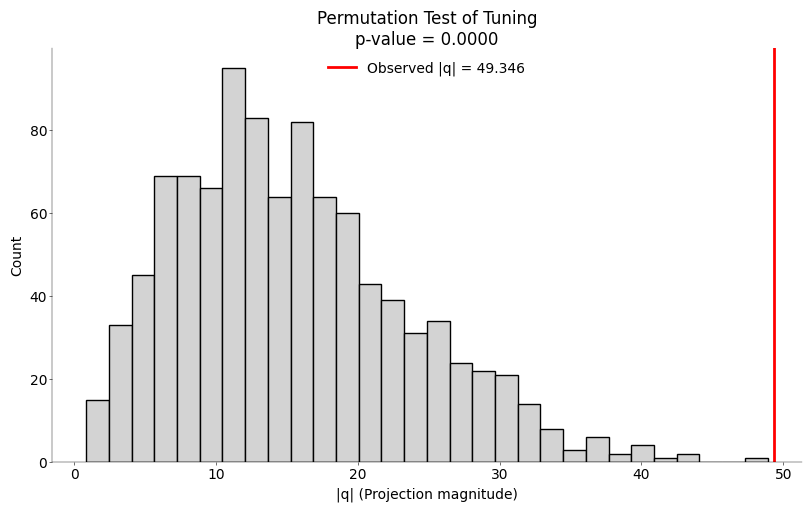

In [62]:
# ---------------------------------------------------------
# Plot null distributions for example cells 28 & 29. (1 pt)
# ---------------------------------------------------------
%matplotlib inline
dirs_sorted_28, counts_sorted_28 = get_data(spikes, 28)
p, q, distr = testTuning(counts_sorted_28, dirs_sorted_28, show=True)

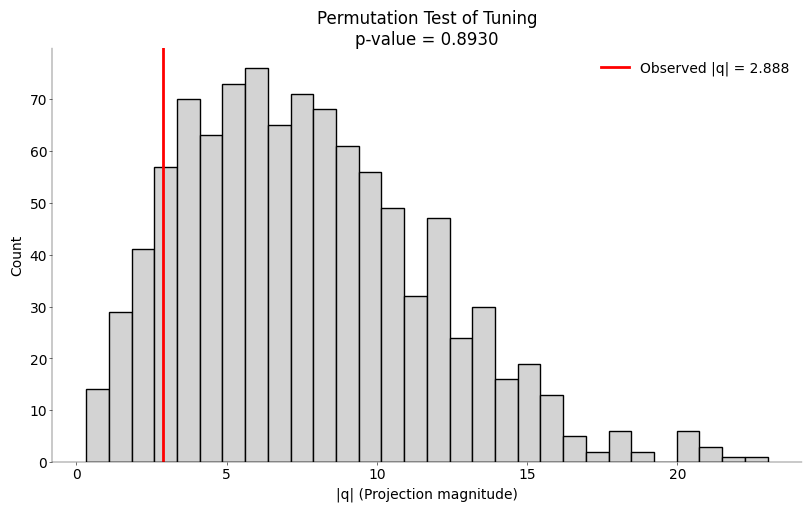

In [71]:
dirs_sorted_29, counts_sorted_29 = get_data(spikes, 41)
p, q, distr = testTuning(counts_sorted_29, dirs_sorted_29, show=True)

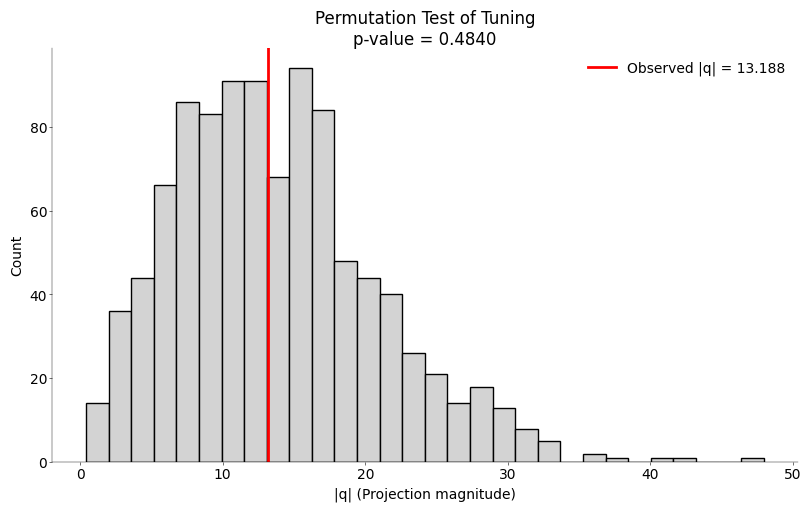

In [80]:
dirs_sorted_2, counts_sorted_2 = get_data(spikes, 2)
p, q, distr = testTuning(counts_sorted_2, dirs_sorted_2, psi=1, show=True)

Test all cells for orientation and direction tuning

In [75]:
# --------------------------------------------------
# Test all cells for orientation / direction tuning.
# Which ones are selective? (0.5 pts)
# --------------------------------------------------


def test_all_neurons(
    spikes, neuron_ids, psi=1, niters=1000, show=False, random_seed=2046
):
    """
    Runs testTuning on all neurons and returns a list of tuples with neuron_id and p-value.

    Parameters
    ----------
    spikes : pd.DataFrame
        The dataframe containing spike data.

    neuron_ids : iterable
        Iterable of neuron IDs to test.

    psi : int
        Fourier component to test (1 = direction, 2 = orientation).

    niters : int
        Number of permutations for the test.

    show : bool
        Whether to show the plot for each neuron (usually False).

    random_seed : int
        Random seed for reproducibility.

    Returns
    -------
    results : list of tuples
        Each tuple is (neuron_id, p_value).
    """
    results = []
    for neuron in neuron_ids:
        dirs_sorted, counts_sorted = get_data(spikes, neuron)
        p_value, _, _ = testTuning(
            counts_sorted,
            dirs_sorted,
            psi=psi,
            niters=niters,
            show=show,
            random_seed=random_seed,
        )
        results.append((neuron, p_value))
    return results

Number of direction tuned neurons:

In [76]:
neuron_ids = range(1, 42)  # assuming neuron IDs from 1 to 41
results = test_all_neurons(spikes, neuron_ids, psi=1, niters=1000, show=False)

# Filter neurons with p < 0.01
significant_neurons = [nid for nid, p in results if p < 0.01]
print(f"Number of direction tuned neurons at p < 0.01: {len(significant_neurons)}")
print("Direction tuned neurons:", significant_neurons)

Number of tuned neurons at p < 0.01: 12
Tuned neurons: [13, 20, 24, 25, 27, 28, 29, 31, 32, 37, 38, 40]


In [81]:
p_values = [p for _, p in results]

# Bonferroni correction threshold
alpha = 0.01
bonferroni_threshold = alpha / len(p_values)

# Filter neurons significant after Bonferroni correction
significant_neurons = [nid for (nid, p) in results if p < bonferroni_threshold]

print(
    f"Number of direction tuned neurons at Bonferroni-corrected p < {alpha}: {len(significant_neurons)}"
)
print("Direction tuned neurons:", significant_neurons)

Number of direction tuned neurons at Bonferroni-corrected p < 0.01: 10
Direction tuned neurons: [13, 20, 24, 27, 28, 31, 32, 37, 38, 40]


Number of orientation tuned neurons:

In [82]:
results = test_all_neurons(spikes, neuron_ids, psi=2, niters=1000, show=False)

# Filter neurons with p < 0.01
significant_neurons = [nid for nid, p in results if p < 0.01]
print(f"Number of orientation tuned neurons at p < 0.01: {len(significant_neurons)}")
print("Orientation tuned neurons:", significant_neurons)

Number of orientation tuned neurons at p < 0.01: 34
Orientation tuned neurons: [2, 3, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41]


In [83]:
p_values = [p for _, p in results]
bonferroni_threshold = alpha / len(p_values)
significant_neurons = [nid for (nid, p) in results if p < bonferroni_threshold]

print(
    f"Number of orientation tuned neurons at Bonferroni-corrected p < {alpha}: {len(significant_neurons)}"
)
print("Orientation tuned neurons:", significant_neurons)

Number of orientation tuned neurons at Bonferroni-corrected p < 0.01: 30
Orientation tuned neurons: [2, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41]
